In [1]:
from urllib.parse import urlparse
from urllib.parse import urldefrag

from urllib.request import urlopen
from file_storage import FileStorage

from bs4 import BeautifulSoup
from urllib.parse import urljoin

from queue import Queue

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def extract_links_from_html(url, html):
    parser = BeautifulSoup(html, "lxml")
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]

In [3]:
fs = FileStorage('storage')

In [4]:
data = pd.read_csv('page_rank_simple_wiki.csv')

PR = {}

for index, row in tqdm_notebook(data.iterrows()):
    PR[row['url']] = row['pageRank']

---
### Сверх читерная

In [5]:
data = pd.read_csv('page_rank_simple_wiki.csv')

pr = data['pageRank'].to_numpy()

too_unfair_wc = pr.cumsum() 

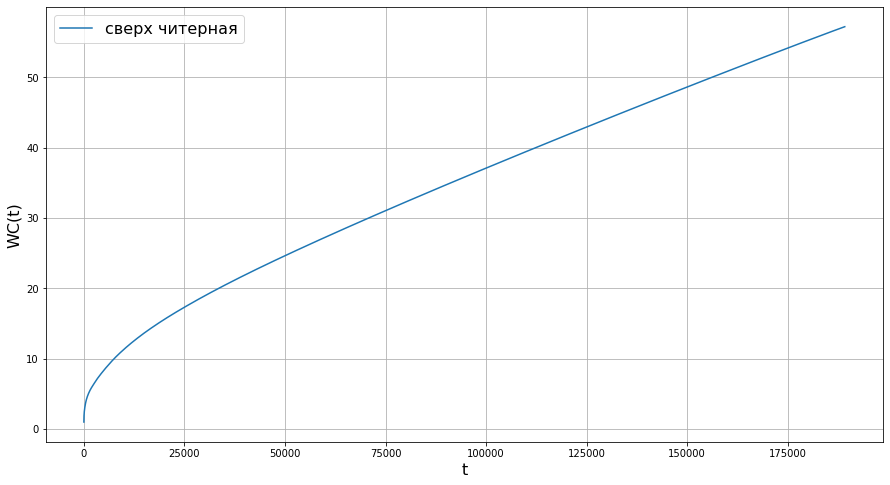

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(pr.shape[0]), too_unfair_wc, label='сверх читерная')
plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
### Читерная

In [7]:
import heapq

In [8]:
h = [(-data['pageRank'][0], data['url'][0])]
s = set()
s.add(data['url'][0])

cumsum = 0
unfair_wc = []

for i in tqdm_notebook(range(len(data))):
    
    if len(h) == 0:
        break
    
    url_pr, url = heapq.heappop(h)
    url_pr *= -1
    
    cumsum += url_pr
    unfair_wc.append(cumsum)
    
    links = extract_links_from_html(url, fs.read(url))
    for link in links:
        link = urldefrag(link).url
        
        if link in PR and link not in s:
            
            heapq.heappush(h, (-PR[link], link))
            s.add(link)
            
unfair_wc = np.asarray(unfair_wc)

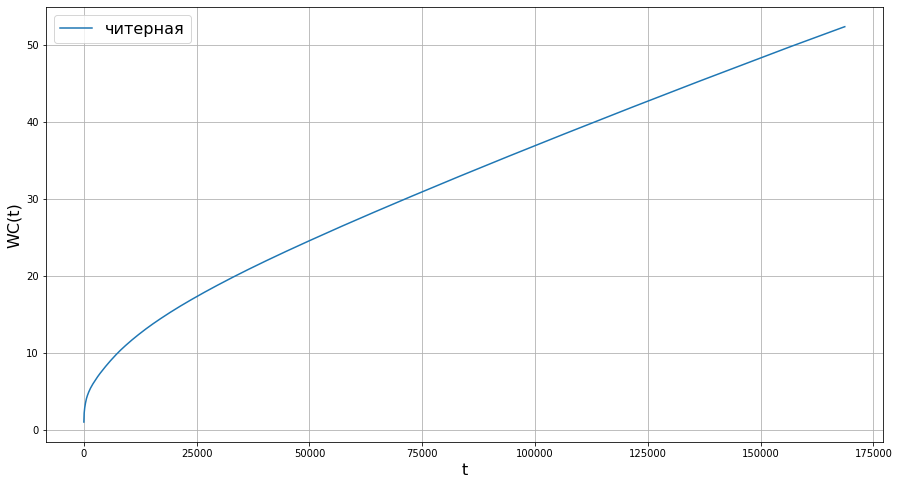

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(unfair_wc.shape[0]), unfair_wc, label='читерная')
plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
### Обход в ширину

In [10]:
q = Queue()
q.put(data['url'][0]) 
s = set()
s.add(data['url'][0])

cumsum = 0
bfs_wc = []

for i in tqdm_notebook(range(len(data))):
    
    if q.qsize() == 0:
        break
    
    url = q.get()
    
    cumsum += PR[url]
    bfs_wc.append(cumsum)
    
    links = extract_links_from_html(url, fs.read(url))
    for link in links:
        link = urldefrag(link).url
        
        if link in PR and link not in s:
            
            q.put(link)
            s.add(link)
            
bfs_wc = np.asarray(bfs_wc)

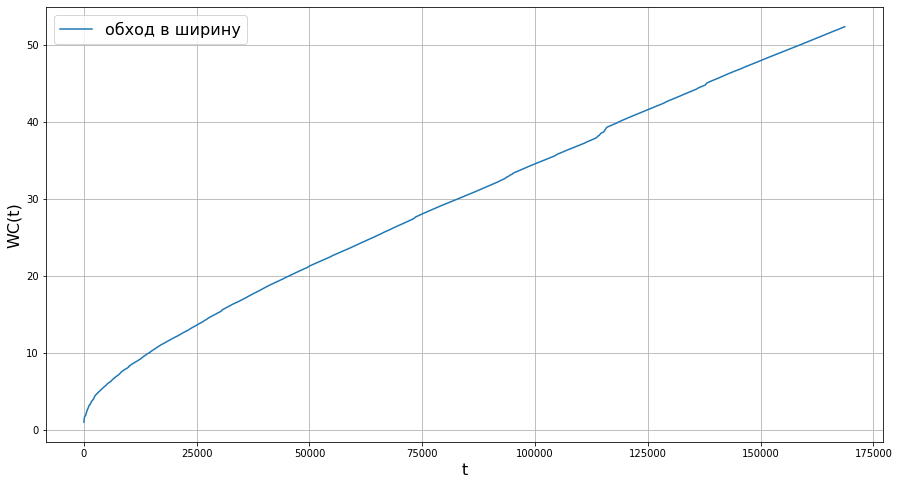

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(bfs_wc.shape[0]), bfs_wc, label='обход в ширину')
plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
### Случайный выбор

Чтобы реализовать случайный выбор урла, в качестве приоритета будем брать случайное число.

In [12]:
h = [(np.random.rand(1), data['url'][0])]
s = set()
s.add(data['url'][0])

cumsum = 0
random_wc = []

for i in tqdm_notebook(range(len(data))):
    
    if len(h) == 0:
        break
    
    _, url = heapq.heappop(h)
    
    cumsum += PR[url]
    random_wc.append(cumsum)
    
    links = extract_links_from_html(url, fs.read(url))
    for link in links:
        link = urldefrag(link).url
        
        if link in PR and link not in s:
            
            heapq.heappush(h, (np.random.rand(1), link))
            s.add(link)
            
random_wc = np.asarray(random_wc)

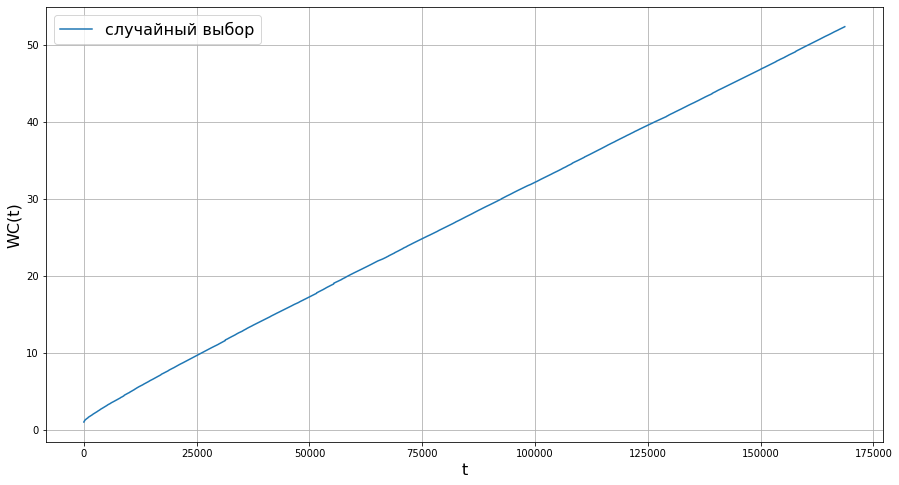

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(random_wc.shape[0]), random_wc, label='случайный выбор')
plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
# Приоритезация

In [14]:
import operator

links_in = dict(zip(data['url'], np.zeros(len(data))))

del links_in[data['url'][0]]

cumsum = 0
priority_wc = []

for i in tqdm_notebook(range(len(data))):
    
    if len(links_in) == 0:
        break
    
    url = max(links_in.items(), key=operator.itemgetter(1))[0]
    del links_in[url]
    
    cumsum += PR[url]
    priority_wc.append(cumsum)
    
    links = extract_links_from_html(url, fs.read(url))
    for link in links:
        link = urldefrag(link).url
        
        if link in links_in:
            links_in[link] += 1
            
priority_wc = np.asarray(priority_wc)

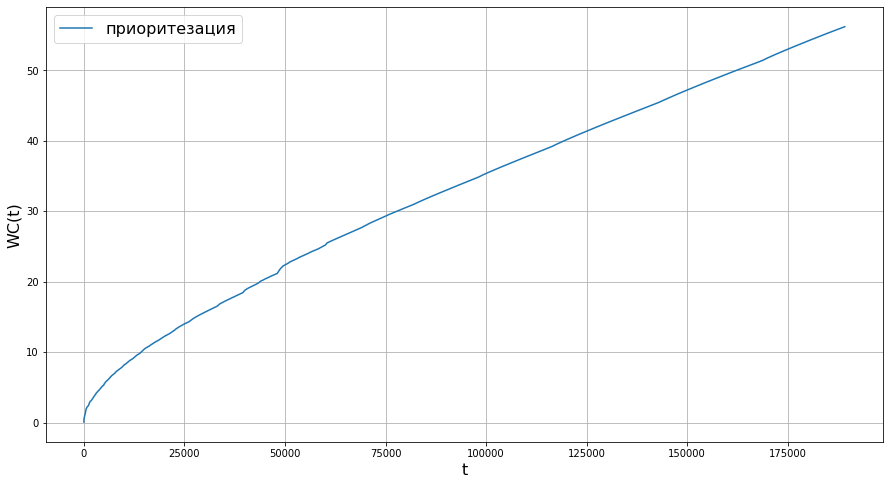

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(priority_wc.shape[0]), priority_wc, label='приоритезация')
plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
### Все вместе

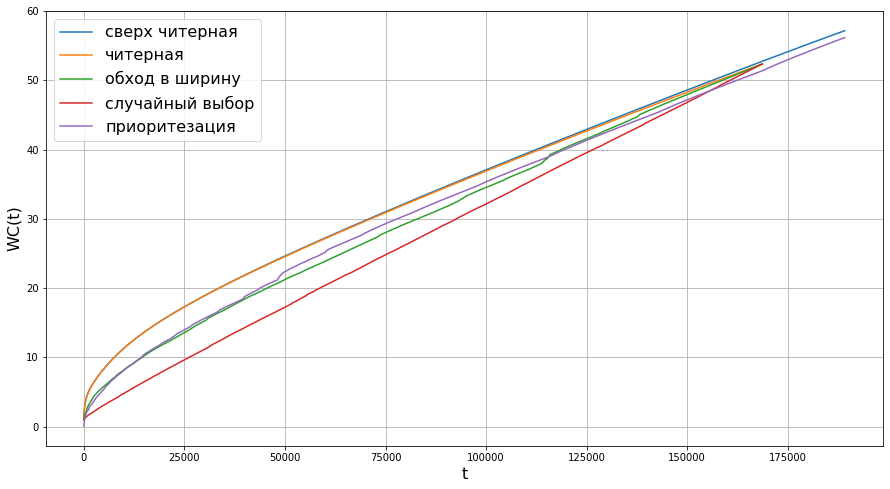

In [17]:
plt.figure(figsize=(15, 8))

plt.plot(np.arange(pr.shape[0]), too_unfair_wc, label='сверх читерная')
plt.plot(np.arange(unfair_wc.shape[0]), unfair_wc, label='читерная')
plt.plot(np.arange(bfs_wc.shape[0]), bfs_wc, label='обход в ширину')
plt.plot(np.arange(random_wc.shape[0]), random_wc, label='случайный выбор')
plt.plot(np.arange(priority_wc.shape[0]), priority_wc, label='приоритезация')

plt.legend(fontsize=16)
plt.xlabel('t', fontsize=16)
plt.ylabel('WC(t)', fontsize=16)
plt.grid()
plt.show()

---
### Вывод

Результат получился ожидаемый: читерная и сверх читерная стратегии показали наилучший результат, а случайный выбор - наихудший. Приоритезация же оказалась чуть лучше, чем обычный обход в ширину.